<a href="https://colab.research.google.com/github/uliebal/RWTH-QMB1/blob/master/1904_QuantMiBi2_CobraPy_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seminar Quantitativ Microbiology 2: 
# Simulation of Genome Scale Metabolic Models with CobraPy

## Introduction
The seminar provides a guide of how to work with genome scale metabolic models (GSMM) of micro-organisms. This seminar extends the introduction to CobraPy from the seminar in Quantitative Microbiology 1. The goal of this seminar is to identify minimal medium composition, extract information about and selecting the appropriate biomass composition formula and testing the reproduction of experimental data by the GSMM. We examine a recent model of *P. pastoris* ([Tomas-Gamisans et al., 2017](https://dx.doi.org/10.1111/1751-7915.12871)). This organism is of biotechnological relevance because it can glycosylate recombinant proteins for use as drugs and it can metabolize methanol as a potential alternative to petrol based chemistry ([Liebal et al., 2018](https://dx.doi.org/10.1016/j.mec.2018.e00075)).

We will analyse the GSMM of *P. pastoris* to estimate for the exchange reactions the range of permissible flux values. This indicates which phenotypes we can expect during standard cultivation and can highlight easily overproduced metabolites. Subsequently, we will identify the minimal medium composition. An important property of GSMM is their ability to predict growth rates. We will extract experimentally measured growth rates for various substrates and compare them with predictions of the model. The data reproduction is exemplified with the substrates of methanol and glycerol and the self-learning task is to supplement growth rates based on glucose uptake rate from literature ([Lehnen et al., 2017](https://dx.doi.org/10.1016/j.meteno.2017.07.001)).

The seminar uses Jupyter notebooks, a new way to use and visualize code in the web. Such a notebook is composed of a sequence of cells. Cellls can be either text/comments, like this introduction, or it contains python code to be run. In this example the code is evaluated by the cloud service [Binder](https://mybinder.org/). The output for each code-cell is shown directly below it. For a overview on Jupyter notebooks read [this review](https://www.nature.com/articles/d41586-018-07196-1). Another usefull resource to develop Jupyter notebooks is via [Google Colaboration](https://colab.research.google.com).


---

## Tutorial Steps
  * Set up of Python environment
    * Basic libraries(sys, pandas, numpy, matplotlib, zipfile, cobrapy)
  * Analysis of Genome Scale Metabolic Model
    * Retrieval of GSMM for *P. pastoris*
    * Flux variability of exchange reactions
    * Minimal medium composition
  * Experimental growth rate reproduction
    * Familiarizing with biomass composition reactions
    * Defining functions for correct biomass equation switch
    * Data retrieval
    * Simulation loop
    * Graphical output


## Set-up compute environment

Before we can analyse GSMM, we have adjust the python environment that it integrates the cobrapy toolbox and downloading the GSMM.

### Basic Python libraries 
Some libraries that facilitate data manipulation

In [0]:
import sys # loading commands to control/navigate within the system architecture
# Loading pandas, a library for data manipulation
!{sys.executable} -m pip install pandas
import pandas as pd

# Loading numpy, a library fo manipulation of numbers
import numpy as np

# loading matplotlib, a library for visualization
!{sys.executable} -m pip install matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# in order to extraact the GSMM we need to process zip-files
import zipfile

# loading cobrapy, a library dedicated to the analysis of genome scale metabolic models
!{sys.executable} -m pip install git+https://github.com/opencobra/cobrapy;
from cobra.io import read_sbml_model

## Analysis of Genome Scale Metabolic Model

### Retrieval of GSMM for *P. pastoris*

*P. pastoris* is an important biotechnological organism and several GSMMs have been generated. We will use the model generated by [Tomas-Gamisans et al., 2017](https://dx.doi.org/10.1111/1751-7915.12871). First, we download the zipped model and extract it. Subsequently we load it into cobra.

In [0]:
!wget https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5743807/bin/MBT2-11-224-s003.zip
with zipfile.ZipFile('MBT2-11-224-s003.zip', 'r') as zip_ref:
  zip_ref.extractall()


In [0]:
from IPython.utils import io
# suppress output, because hundreds of warnings are generated
with io.capture_output() as captured:
  # generating cobra variable from SBML/xml file
  model = read_sbml_model('folder/mbt212871-sup-0003-AppendixS3.xml');

In [0]:
# check on model consistency
model

### Flux variability of exchange reactions

Flux balance analysis provides a single optimal solution. Mostly, there exist a number of alternative flux distributions around the optimum, which can be physiologically relevant. To identify the variability of exchange fluxes around the optimum solution 'flux variability analysis' can be performed ([Mahadevan & Schilling, 2003](http://dx.doi.org/10.1016/j.ymben.2003.09.002)).

In [0]:
solution = model.optimize()
model.summary(fva=.95) # additional argument specifies allowed deviation from the optimum

### Media test
The availability of nutrients has a major impact on metabolic fluxes and cobrapy provides some helpers to manage the exchanges between the external environment and the metabolic model. More detailed descriptions: [here](https://cobrapy.readthedocs.io/en/latest/media.html)

In [0]:
from cobra.medium import minimal_medium

max_growth = model.slim_optimize()
minimal_medium(model, max_growth, minimize_components=True)


## Experimental growth rate reproduction

### Familiarizing with biomass composition reactions

Microorganisms adapt to their substrate. Different substrates provide different energy content and require different cellular resources to become metabolized. In GSMM these differences may be represented by different equations/reactions for the substrates. In iMR1026 for *P. pastoris* there are various biomass equations for glucose, glycerol, glucose-glycerol mixtures, and methanol. When simulating a model, we have to make sure we use the right biomass equation fitting with the substrate.

In [0]:
# List of all reactions with 'BIOMASS' in their name
model.reactions.query('BIOMASS')

In [0]:
# Looking in detail to biomass with methanol
model.reactions.BIOMASS_meoh

### Defining functions for correct biomass equation switch

For each substrate, the boundary exchange fluxes are activated and the reactions of competing substrates are disabled.

Remember to write a specific function to adapt the model for glucose utilization.

In [0]:
def AdaptMethanol(model, meoh_up):
  model.objective = 'BIOMASS_meoh'
  # setting uptake reactions right
  model.reactions.Ex_glc_D.lower_bound = 0
  model.reactions.Ex_glyc.lower_bound = 0
  model.reactions.Ex_meoh.lower_bound = -np.abs(meoh_up)
  # setting additional biomass composition
  model.reactions.LIPIDS_meoh.upper_bound = 1000
  model.reactions.PROTEINS_meoh.upper_bound = 1000
  model.reactions.STEROLS_meoh.upper_bound = 1000
  model.reactions.BIOMASS_meoh.upper_bound = 1000
  # deactivating Glyc-based biomass composition
  model.reactions.LIPIDS_glyc.upper_bound = 0
  model.reactions.PROTEINS_glyc.upper_bound = 0
  model.reactions.STEROLS_glyc.upper_bound = 0
  model.reactions.BIOMASS_glyc.upper_bound = 0  
  # deactivating Glc-based biomass composition
  model.reactions.LIPIDS.upper_bound = 0
  model.reactions.PROTEINS.upper_bound = 0
  model.reactions.STEROLS.upper_bound = 0
  model.reactions.BIOMASS.upper_bound = 0  
  return model

def AdaptGlycerol(model, glyc_up):
  model.objective = 'BIOMASS_glyc'
  # setting uptake reactions right
  model.reactions.Ex_meoh.lower_bound = 0;
  model.reactions.Ex_glc_D.lower_bound = 0;
  model.reactions.Ex_glyc.lower_bound = -np.abs(glyc_up)
  # setting additional biomass composition
  model.reactions.LIPIDS_glyc.upper_bound = 1000
  model.reactions.PROTEINS_glyc.upper_bound = 1000
  model.reactions.STEROLS_glyc.upper_bound = 1000
  model.reactions.BIOMASS_glyc.upper_bound = 1000  
  # deactivating MeOH-based biomass composition
  model.reactions.LIPIDS_meoh.upper_bound = 0
  model.reactions.PROTEINS_meoh.upper_bound = 0
  model.reactions.STEROLS_meoh.upper_bound = 0
  model.reactions.BIOMASS_meoh.upper_bound = 0
  # deactivating Glc-based biomass composition
  model.reactions.LIPIDS.upper_bound = 0
  model.reactions.PROTEINS.upper_bound = 0
  model.reactions.STEROLS.upper_bound = 0
  model.reactions.BIOMASS.upper_bound = 0
  return model

def AdaptGlucose(model, glc_up):
  model.objective = 'BIOMASS'
  # setting uptake reactions right
  model.reactions.Ex_meoh.lower_bound = 0
  model.reactions.Ex_glyc.lower_bound = 0
  model.reactions.Ex_glc_D.lower_bound = -np.abs(glc_up)
  # setting additional biomass composition
  model.reactions.LIPIDS.upper_bound = 1000
  model.reactions.PROTEINS.upper_bound = 1000
  model.reactions.STEROLS.upper_bound = 1000
  model.reactions.BIOMASS.upper_bound = 1000  
  # deactivating Glyc-based biomass composition
  model.reactions.LIPIDS_glyc.upper_bound = 0
  model.reactions.PROTEINS_glyc.upper_bound = 0
  model.reactions.STEROLS_glyc.upper_bound = 0
  model.reactions.BIOMASS_glyc.upper_bound = 0  
  # deactivating Glc-based biomass composition
  model.reactions.LIPIDS_meoh.upper_bound = 0
  model.reactions.PROTEINS_meoh.upper_bound = 0
  model.reactions.STEROLS_meoh.upper_bound = 0
  model.reactions.BIOMASS_meoh.upper_bound = 0
  return model

### Data retrieval

For evaluation of the growth rate prediction of the *P. pastoris* model we use experimental data from the closely related organism *Ogataea polymorpha*. The measurements in the table are extracted from [van Dijken et al. 1976](https://dx.doi.org/10.1007/bf00446560) for methanol and from [de Koning et al., 1987](https://dx.doi.org/10.1007/BF00456710) and [Moon et al., 2003](https://dx.doi.org/10.1385/ABAB:111:2:65).

Data Address: [here](https://rwth-aachen.sciebo.de/s/o72jwWQWh3ame1e/download)

In [0]:
# data = pd.read_csv('Opol-expt-grwth_.csv')
data = pd.read_csv('/content/Opol-expt-grwth_MeOH-Glyc.csv')
data


Adding measurements for glucose from Lehnen et al., 2017 to our basic data table.

In [0]:
data = data.append({'Substrate':'Glucose', 'Exchange':'Ex_glc_D', 'uptake rate (mmol/gCDW/h)':5.9, 'Experiment growth rate (/h)':0.6, 'source':'Lehnen et al.'}, ignore_index=True)
# data = data.append({'Substrate':'Glucose', 'Exchange':'???', 'uptake rate (mmol/gCDW/h)':np.nan, 'Experiment growth rate (/h)':np.nan, 'source':'Lehnen et al.'}, ignore_index=True)data 

### Simulation loop
For-Loop over all experimental data points.

Remember to add a decision when you include glucose.

In [0]:
growth_simulated = [];
# test_model = model.copy()
# iteration over all rows in 'data'
for index, row in data.iterrows():
  with model as test_model:
    print(index) # printing the row number to get feedback that everything is working
    # selecting the right substrate in the model based on 'Substrate' in 'data'
    if row['Substrate'] == 'Methanol':
      model = AdaptMethanol(test_model, row['uptake rate (mmol/gCDW/h)'])
    elif row['Substrate'] == 'Glucose':
      model = AdaptGlucose(test_model, row['uptake rate (mmol/gCDW/h)'])
    elif row['Substrate'] == 'Glycerol':
      model = AdaptGlycerol(test_model, row['uptake rate (mmol/gCDW/h)'])
    else:
      print('substrate not considered')      
  #     model.optimize()
    growth_simulated.append(model.slim_optimize())


### Graphical output

Remember to add glucose to the visualization.

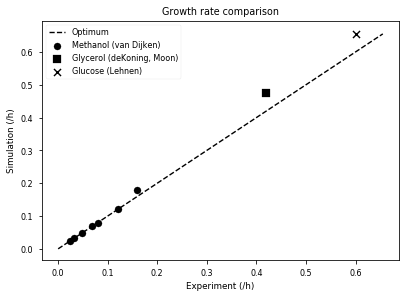

In [93]:
plt.scatter(data['Experiment growth rate (/h)'][0:7], growth_simulated[0:7], s=50, c='k', marker='o');
plt.scatter(data['Experiment growth rate (/h)'][7], growth_simulated[7], s=50, c='k', marker='s');
plt.scatter(data['Experiment growth rate (/h)'][8], growth_simulated[8], s=50, c='k', marker='x');
plt.xlabel('Experiment (/h)');
plt.ylabel('Simulation (/h)');
myline = np.linspace(0,np.max(growth_simulated),10);
plt.plot(myline,myline,'k--');
plt.title('Growth rate comparison');
plt.legend(['Optimum','Methanol (van Dijken)','Glycerol (deKoning, Moon)','Glucose (Lehnen)'], loc=2);
plt.style.use('seaborn-paper')

# Saving figure
plt.savefig('iMT1026_exp-vs-sim.png')